# Import packages and data

In [1]:
import pandas as pd
import numpy as np
import shap
from sklearn.model_selection import train_test_split
import lightgbm as lgb
from sklearn.metrics import classification_report
import warnings
warnings.filterwarnings('ignore')

In [2]:
data, target = shap.datasets.adult()

In [41]:
raw_data, target = shap.datasets.adult(display=True)

# Explore data

In [3]:
data.head()

,Age,Workclass,Education-Num,Marital Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country
0,39.0,7,13.0,4,1,0,4,1,2174.0,0.0,40.0,39
1,50.0,6,13.0,2,4,4,4,1,0.0,0.0,13.0,39
2,38.0,4,9.0,0,6,0,4,1,0.0,0.0,40.0,39
3,53.0,4,7.0,2,6,4,2,1,0.0,0.0,40.0,39
4,28.0,4,13.0,2,10,5,2,0,0.0,0.0,40.0,5


In [42]:
raw_data.head()

,Age,Workclass,Education-Num,Marital Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country
0,39.0,State-gov,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States
1,50.0,Self-emp-not-inc,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,13.0,United-States
2,38.0,Private,9.0,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.0,0.0,40.0,United-States
3,53.0,Private,7.0,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.0,0.0,40.0,United-States
4,28.0,Private,13.0,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.0,0.0,40.0,Cuba


In [44]:
map_df = data.join(raw_data, rsuffix='_raw')

In [47]:
map_df[['Workclass', 'Workclass_raw']].drop_duplicates()

,Workclass,Workclass_raw
0,7,State-gov
1,6,Self-emp-not-inc
2,4,Private
22,1,Federal-gov
25,2,Local-gov
27,0,?
54,5,Self-emp-inc
1901,8,Without-pay
5361,3,Never-worked


In [48]:
map_df[['Marital Status', 'Marital Status_raw']].drop_duplicates()

,Marital Status,Marital Status_raw
0,4,Never-married
1,2,Married-civ-spouse
2,0,Divorced
6,3,Married-spouse-absent
21,5,Separated
37,1,Married-AF-spouse
147,6,Widowed


In [49]:
map_df[['Relationship', 'Relationship_raw']].drop_duplicates()

,Relationship,Relationship_raw
0,0,Not-in-family
1,4,Husband
4,5,Wife
12,3,Own-child
17,1,Unmarried
74,2,Other-relative


In [50]:
map_df[['Race', 'Race_raw']].drop_duplicates()

,Race,Race_raw
0,4,White
3,2,Black
11,1,Asian-Pac-Islander
15,0,Amer-Indian-Eskimo
50,3,Other


In [51]:
map_df[['Sex', 'Sex_raw']].drop_duplicates()

,Sex,Sex_raw
0,1,Male
4,0,Female


In [52]:
map_df[['Occupation', 'Occupation_raw']].drop_duplicates()

,Occupation,Occupation_raw
0,1,Adm-clerical
1,4,Exec-managerial
2,6,Handlers-cleaners
4,10,Prof-specialty
6,8,Other-service
13,12,Sales
14,3,Craft-repair
15,14,Transport-moving
16,5,Farming-fishing
17,7,Machine-op-inspct


In [4]:
data.describe()

,Age,Workclass,Education-Num,Marital Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country
count,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000
mean,38.581646,3.868892,10.080679,2.611836,6.572740,2.494518,3.665858,0.669205,1077.648804,87.303833,40.437454,36.718866
std,13.640432,1.455960,2.572720,1.506222,4.228857,1.758232,0.848806,0.470506,7385.291992,402.960205,12.347429,7.823782
min,17.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,28.000000,4.000000,9.000000,2.000000,3.000000,0.000000,4.000000,0.000000,0.000000,0.000000,40.000000,39.000000
50%,37.000000,4.000000,10.000000,2.000000,7.000000,3.000000,4.000000,1.000000,0.000000,0.000000,40.000000,39.000000
75%,48.000000,4.000000,12.000000,4.000000,10.000000,4.000000,4.000000,1.000000,0.000000,0.000000,45.000000,39.000000
max,90.000000,8.000000,16.000000,6.000000,14.000000,5.000000,4.000000,1.000000,99999.000000,4356.000000,99.000000,41.000000


In [5]:
target

array([False, False, False, ..., False, False,  True])

In [6]:
print(f"Percent making over $50k: {round(sum(target)/len(target)*100,2)}%")

Percent making over $50k: 24.08%


# Split data into train and test sets

In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    data, target, test_size=0.33, random_state=42)

In [8]:
print(f"Percent making over $50k in training set: {round(sum(y_train)/len(y_train)*100,2)}%")

Percent making over $50k in training set: 24.25%


In [9]:
print(f"Percent making over $50k in test set: {round(sum(y_test)/len(y_test)*100,2)}%")

Percent making over $50k in test set: 23.73%


# Train model

I know we're skipping a few steps here...

In [10]:
lgb_model = lgb.LGBMClassifier(random_state=42)
lgb_model.fit(X_train, y_train)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 5291, number of negative: 16524
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000747 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 414
[LightGBM] [Info] Number of data points in the train set: 21815, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.242540 -> initscore=-1.138807
[LightGBM] [Info] Start training from score -1.138807


LGBMClassifier(random_state=42)

# Predict on test data

In [11]:
pred = lgb_model.predict(X_test)

In [12]:
proba = lgb_model.predict_proba(X_test)

In [13]:
print(f"Percent predicted to make over $50k in test set: {round(sum(pred)/len(pred)*100,2)}%")

Percent predicted to make over $50k in test set: 20.37%


# Analyze model performance

In [14]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

       False       0.90      0.94      0.92      8196
        True       0.78      0.67      0.72      2550

    accuracy                           0.88     10746
   macro avg       0.84      0.80      0.82     10746
weighted avg       0.87      0.88      0.87     10746



<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

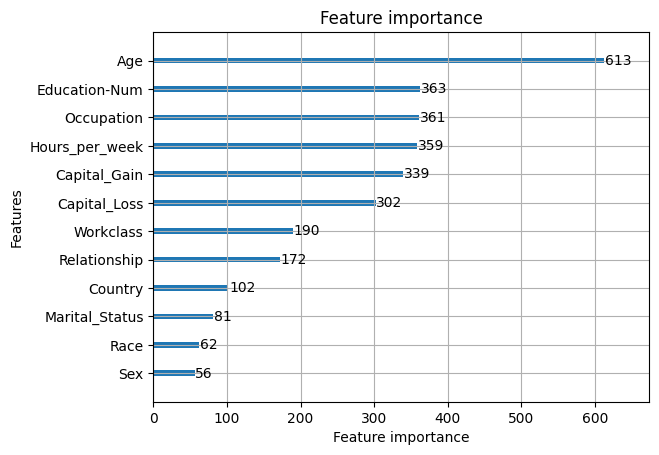

In [40]:
lgb.plot_importance(lgb_model)

# SHAP!

In [15]:
explainer = shap.Explainer(lgb_model, algorithm="tree")

In [16]:
shap_values = explainer(X_test)

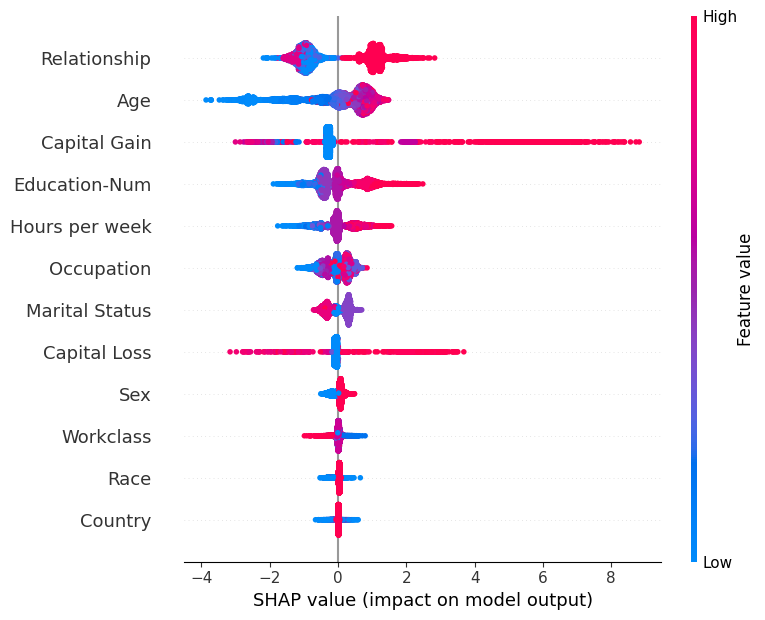

In [17]:
shap.summary_plot(shap_values, X_test)

In [18]:
print(pred[0]) 
print(proba[0])

False
[0.99541976 0.00458024]


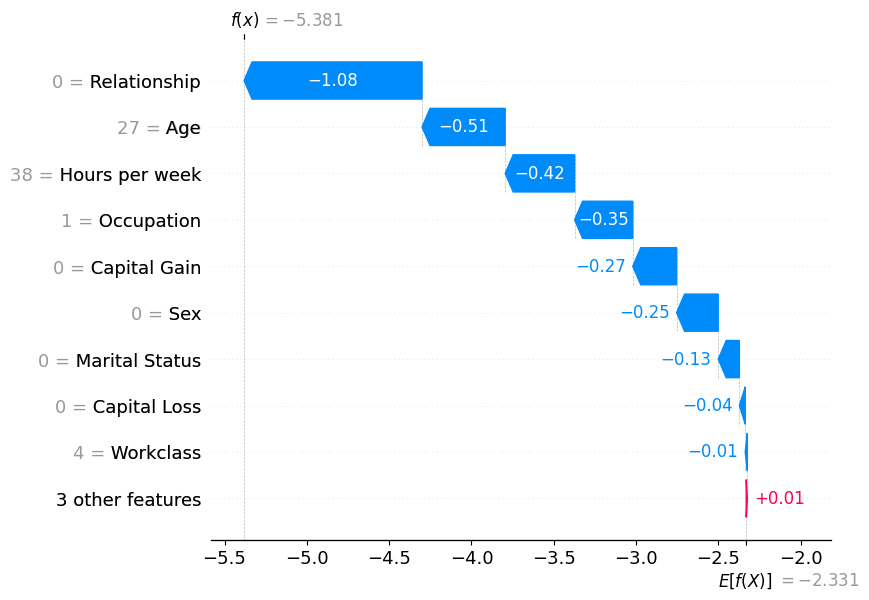

In [19]:
shap.plots.waterfall(shap_values[0])

In [20]:
print(pred[1]) 
print(proba[1])

False
[0.56373096 0.43626904]


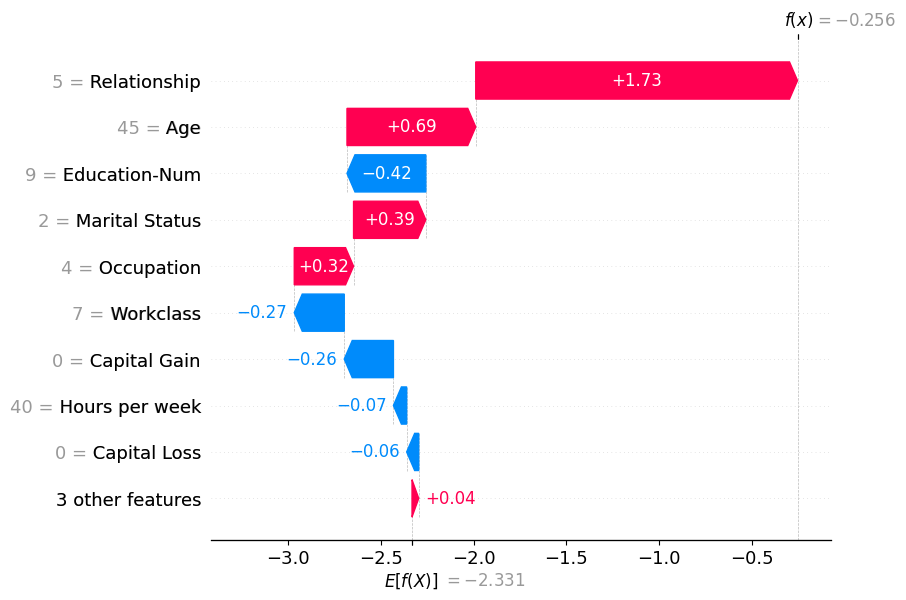

In [21]:
shap.plots.waterfall(shap_values[1])

In [22]:
print(pred[2]) 
print(proba[2])

True
[0.26467178 0.73532822]


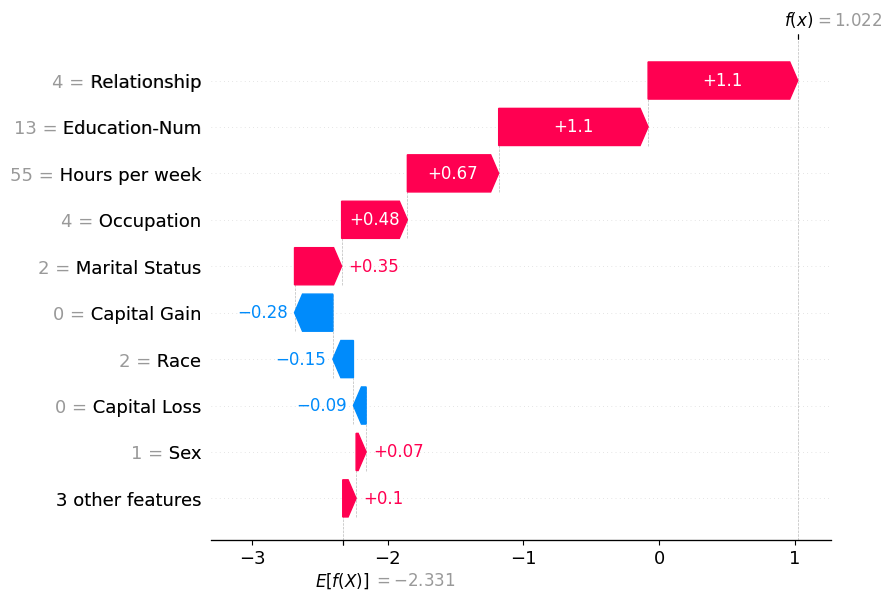

In [23]:
shap.plots.waterfall(shap_values[2])

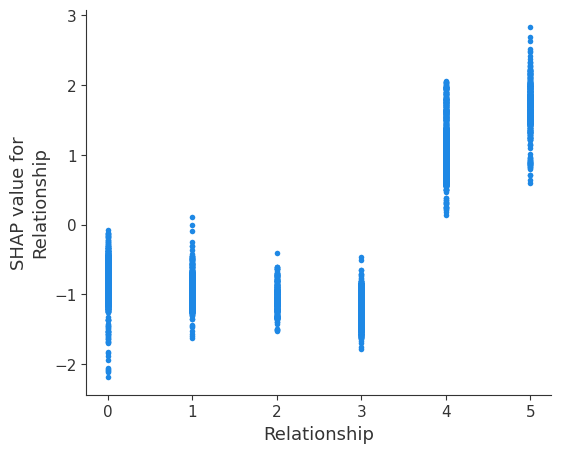

In [37]:
shap.dependence_plot(
    "Relationship",
    shap_values.values,
    X_test,
    interaction_index=None
)

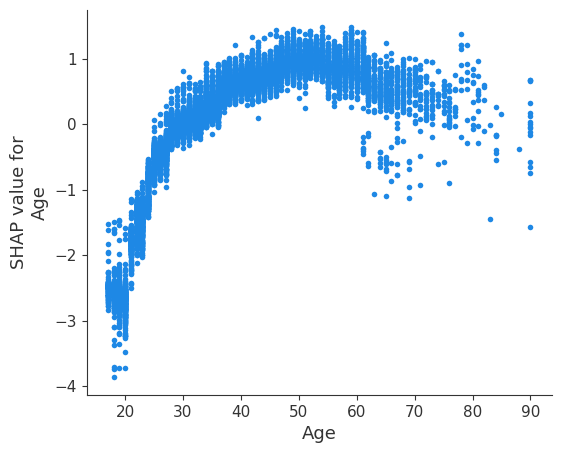

In [38]:
shap.dependence_plot(
    "Age",
    shap_values.values,
    X_test,
    interaction_index=None
)

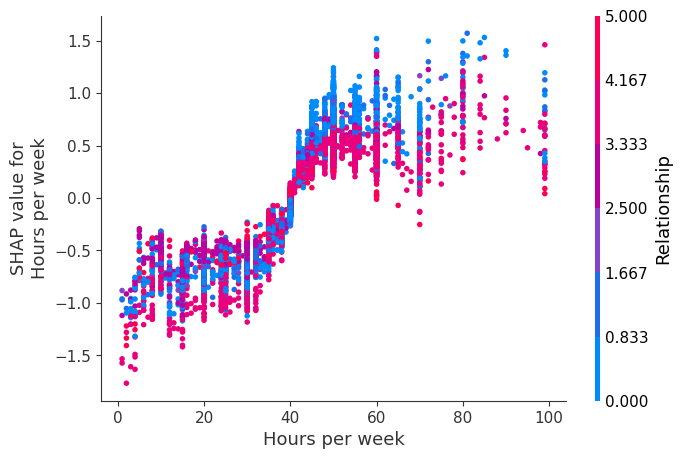

In [39]:
shap.dependence_plot(
    "Hours per week",
    shap_values.values,
    X_test,
    interaction_index="Relationship"
)